[LRLSErrorFeedback] Completed in 89.04 ms


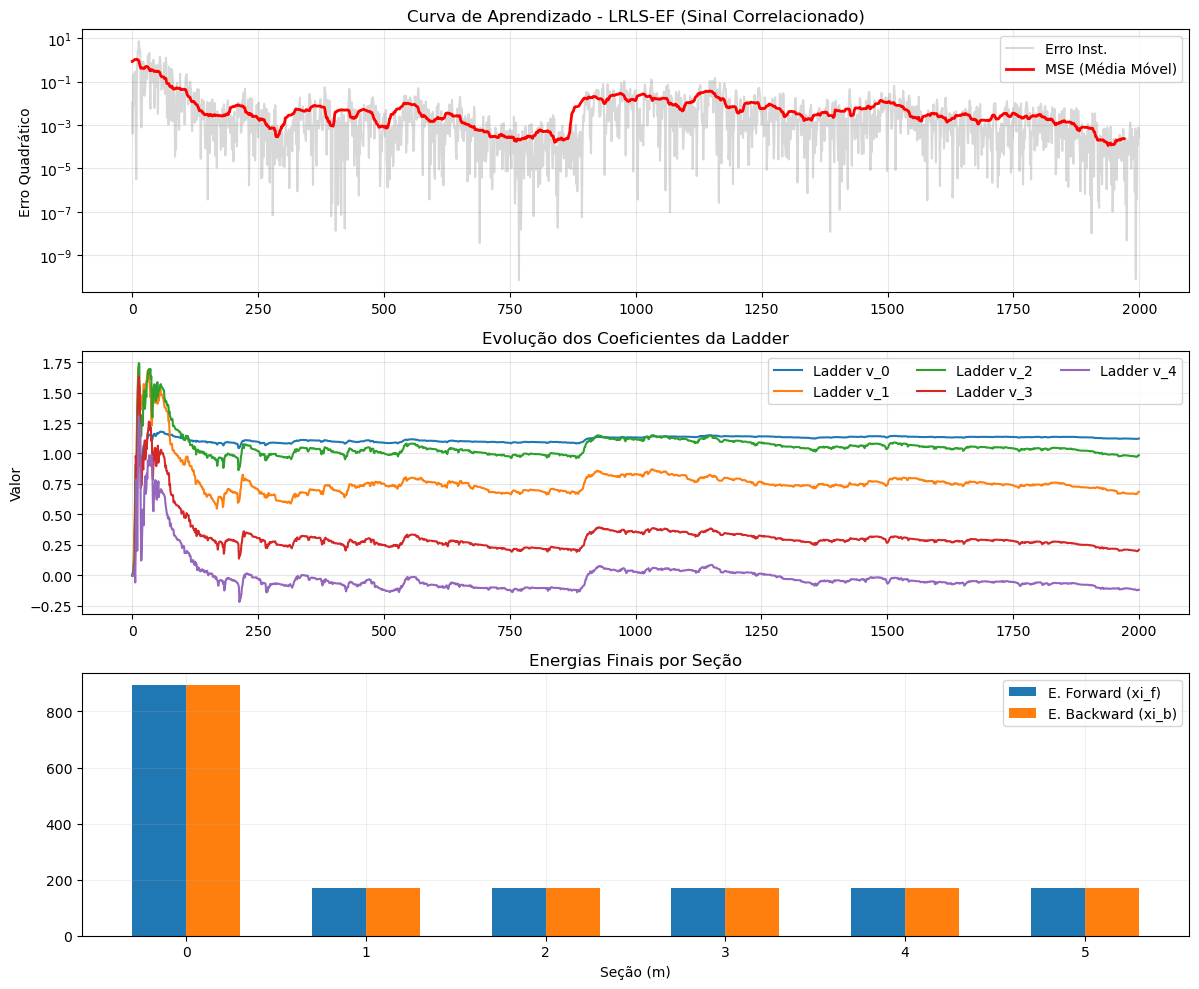

Erro Final Médio: 0.014049


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pydaptivefiltering as pdf

# --- CONFIGURAÇÃO DA SIMULAÇÃO ---
np.random.seed(42)
n_samples = 2000
filter_order = 4  # M seções de lattice

# 1. Gerar entrada "colorida" (Sinal AR(1))
# O LRLS brilha aqui onde o LMS falharia
b_ar, a_ar = [1], [1, -0.9] 
x_white = np.random.randn(n_samples)
x = signal.lfilter(b_ar, a_ar, x_white)
x /= np.std(x) 

# 2. Sistema Desconhecido (Planta FIR)
w_true = np.array([0.5, -0.2, 0.8, 0.3, -0.1])
d_clean = np.convolve(x, w_true, mode='full')[:n_samples]
d = d_clean + 0.01 * np.random.randn(n_samples)

# --- INSTANCIAÇÃO ---
# Nota: Removi o sufixo 'pdf.' para facilitar o teste direto na sua classe
f = pdf.LRLSErrorFeedback(
    filter_order=filter_order, 
    lambda_factor=0.999, 
    epsilon=1.0
)

# --- EXECUÇÃO ---
# Agora chamando sem o erro de atributo interno
result = f.optimize(x, d, verbose=True, return_internal_states=True)


# --- VISUALIZAÇÃO ---
plt.figure(figsize=(12, 10))

# 1. MSE (Aprendizado)
plt.subplot(3, 1, 1)
plt.semilogy(np.abs(result.errors)**2, label='Erro Inst.', alpha=0.3, color='gray')
mse_smooth = np.convolve(np.abs(result.errors)**2, np.ones(30)/30, mode='valid')
plt.semilogy(mse_smooth, label='MSE (Média Móvel)', color='red', lw=2)
plt.title('Curva de Aprendizado - LRLS-EF (Sinal Correlacionado)')
plt.ylabel('Erro Quadrático')
plt.grid(True, which="both", alpha=0.3)
plt.legend()

# 2. Coeficientes da Ladder (v)
plt.subplot(3, 1, 2)
v_hist = np.real(result.coefficients)
for i in range(v_hist.shape[1]):
    plt.plot(v_hist[:, i], label=f'Ladder v_{i}')
plt.title('Evolução dos Coeficientes da Ladder')
plt.ylabel('Valor')
plt.grid(True, alpha=0.3)
plt.legend(ncol=3, loc='upper right')

# 3. Energias Forward e Backward
plt.subplot(3, 1, 3)
xi_f = result.extra["xi_f"]
xi_b = result.extra["xi_b"]
plt.bar(np.arange(len(xi_f)) - 0.15, xi_f, width=0.3, label='E. Forward (xi_f)')
plt.bar(np.arange(len(xi_b)) + 0.15, xi_b, width=0.3, label='E. Backward (xi_b)')
plt.title('Energias Finais por Seção')
plt.xlabel('Seção (m)')
plt.legend()
plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

print(f"Erro Final Médio: {np.mean(np.abs(result.errors[-100:])):.6f}")